## Pet Cats UK — Data Cleaning + Exploratory Data Analysis (BA820)

### Motivation (why we care)
Domestic cats are a high-variability “micro-mobility” population: some stay indoors; others roam widely, hunt frequently, and may interact with wildlife, roads, and neighborhoods. This notebook cleans GPS tracking data and produces an EDA that supports downstream **unsupervised learning** (segmentation, anomalies, similarity).

### Stakeholders
- **Owners / vets**: wellbeing, activity, risk behaviors
- **Wildlife/ecology**: hunting pressure and habitat interaction
- **Community / policy**: human–pet–wildlife interfaces
- **BA820**: a realistic end-to-end cleaning + EDA workflow
---


In [33]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

# Tracking data
tracking_url = "https://drive.google.com/uc?export=download&id=10Ybhoqe677hCHR13pGcaND8u1oWTADGU"
tracking_raw = pd.read_excel(tracking_url)

# Reference data
reference_url = "https://drive.google.com/uc?export=download&id=15UmQF9N5KWlJn2XWjtoutJO8rnqI1U-r"
ref_raw = pd.read_excel(reference_url)

# View the data
print("Tracking Data:")
print(tracking_raw.head())
print("\nReference Data:")
print(ref_raw.head())

Tracking Data:
  tag_id    event_id  visible             timestamp  location_long  \
0   Ares  3395610551     True  2017-06-24T01:03:57Z      -5.113851   
1   Ares  3395610552     True  2017-06-24T01:11:20Z      -5.113851   
2   Ares  3395610553     True  2017-06-24T02:58:16Z      -5.113730   
3   Ares  3395610554     True  2017-06-24T03:01:26Z      -5.113774   
4   Ares  3395610555     True  2017-06-24T03:51:58Z      -5.114247   

   location_lat  ground_speed  height_above_ellipsoid  \
0     50.170315           684                  154.67   
1     50.170315           936                  154.67   
2     50.169876          2340                   81.35   
3     50.169827             0                   67.82   
4     50.170139          4896                  118.03   

   algorithm_marked_outlier  manually_marked_outlier               study_name  
0                     False                    False  Pet Cats United Kingdom  
1                     False                    False  Pet Cat

## Data overview

We start with basic profiling: **shape**, **dtypes**, and **missingness** for both tables.

In [34]:
def overview(df: pd.DataFrame, name: str) -> None:
    print(f"=== {name} ===")
    print("Shape:", df.shape)

    print("\nDtypes:")
    display(df.dtypes.to_frame("dtype"))

    print("\nMissingness (top 25 by missing count):")
    miss = df.isna().sum().sort_values(ascending=False)
    miss = miss[miss > 0].head(25)
    if len(miss) == 0:
        print("No missing values.")
    else:
        display(pd.DataFrame({
            "missing_count": miss,
            "missing_pct": (miss / len(df) * 100).round(2)
        }))

    print("\nSample rows:")
    display(df.head(3))

overview(tracking_raw, "Tracking (raw)")
overview(ref_raw, "Reference (raw)")

=== Tracking (raw) ===
Shape: (18215, 11)

Dtypes:


,dtype
tag_id,object
event_id,int64
visible,bool
timestamp,object
location_long,float64
location_lat,float64
ground_speed,int64
height_above_ellipsoid,float64
algorithm_marked_outlier,bool
manually_marked_outlier,bool



Missingness (top 25 by missing count):
No missing values.

Sample rows:


,tag_id,event_id,visible,timestamp,location_long,location_lat,ground_speed,height_above_ellipsoid,algorithm_marked_outlier,manually_marked_outlier,study_name
0,Ares,3395610551,True,2017-06-24T01:03:57Z,-5.113851,50.170315,684,154.67,False,False,Pet Cats United Kingdom
1,Ares,3395610552,True,2017-06-24T01:11:20Z,-5.113851,50.170315,936,154.67,False,False,Pet Cats United Kingdom
2,Ares,3395610553,True,2017-06-24T02:58:16Z,-5.113730,50.169876,2340,81.35,False,False,Pet Cats United Kingdom


=== Reference (raw) ===
Shape: (101, 16)

Dtypes:


,dtype
tag_id,object
animal_id,object
animal_taxon,object
deploy_on_date,object
deploy_off_date,object
hunt,float64
prey_p_month,float64
animal_reproductive_condition,object
animal_sex,object
hrs_indoors,float64



Missingness (top 25 by missing count):


,missing_count,missing_pct
food_other,10,9.90
hunt,9,8.91
animal_reproductive_condition,3,2.97
age_years,1,0.99



Sample rows:


,tag_id,animal_id,animal_taxon,deploy_on_date,deploy_off_date,hunt,prey_p_month,animal_reproductive_condition,animal_sex,hrs_indoors,n_cats,food_dry,food_wet,food_other,study_site,age_years
0,Tommy-Tag,Tommy,Felis catus,2017-06-03T01:02:09Z,2017-06-10T02:10:52Z,1.0,12.5,Neutered,m,12.5,2,True,True,0.0,UK,11.0
1,Athena,Athena,Felis catus,2017-06-24T01:02:13Z,2017-06-30T23:59:32Z,1.0,3.0,Spayed,f,7.5,2,True,True,0.0,UK,3.0
2,Ares,Ares,Felis catus,2017-06-24T01:03:57Z,2017-06-30T23:58:01Z,NaN,0.0,Neutered,m,7.5,2,True,True,0.0,UK,3.0


## Data cleaning (tracking)

Cleaning goals:
- Parse timestamps reliably
- Deduplicate
- Keep only **visible** points when available
- Remove outliers using both flags (`algorithm_marked_outlier` OR `manually_marked_outlier`)
- Sanity checks: valid lat/long ranges and plausible speeds

We keep row counts at each step for auditability.

In [39]:
tracking = tracking_raw.copy()

# Clean column names
tracking.columns = tracking.columns.str.strip().str.lower().str.replace(' ', '_')

print("=== TRACKING DATA CLEANING ===")
print(f"Starting rows: {len(tracking):,}")

# Parse timestamp
if 'timestamp' in tracking.columns:
    tracking['timestamp_parsed'] = pd.to_datetime(tracking['timestamp'], errors='coerce')
    print(f"1. Parsed timestamps. Unparseable: {tracking['timestamp_parsed'].isna().sum()}")

# Remove duplicates
before = len(tracking)
tracking = tracking.drop_duplicates()
print(f"2. Duplicates removed: {before:,} -> {len(tracking):,}")

# Remove rows with all missing values
before = len(tracking)
tracking = tracking.dropna(how='all')
print(f"3. Empty rows removed: {before:,} -> {len(tracking):,}")

# Filter for visible records only
if 'visible' in tracking.columns:
    before = len(tracking)
    tracking = tracking[tracking['visible'] == True].copy()
    print(f"4. Visible filter: {before:,} -> {len(tracking):,}")

# Remove outliers
if 'algorithm_marked_outlier' in tracking.columns or 'manually_marked_outlier' in tracking.columns:
    before = len(tracking)
    outlier_mask = (
        (tracking.get('algorithm_marked_outlier', False) == True) |
        (tracking.get('manually_marked_outlier', False) == True)
    )
    tracking = tracking[~outlier_mask].copy()
    print(f"5. Outlier removal: {before:,} -> {len(tracking):,}")

# Validate geographic coordinates
if 'location_lat' in tracking.columns and 'location_long' in tracking.columns:
    tracking['location_lat'] = pd.to_numeric(tracking['location_lat'], errors='coerce')
    tracking['location_long'] = pd.to_numeric(tracking['location_long'], errors='coerce')

    before = len(tracking)
    tracking = tracking[
        tracking['location_lat'].between(-90, 90) &
        tracking['location_long'].between(-180, 180)
    ].copy()
    print(f"6. Geographic bounds filter: {before:,} -> {len(tracking):,}")

# Filter unrealistic ground speeds
if 'ground_speed' in tracking.columns:
    tracking['ground_speed'] = pd.to_numeric(tracking['ground_speed'], errors='coerce')

    before = len(tracking)
    MAX_SPEED = 5000
    tracking = tracking[tracking['ground_speed'] <= MAX_SPEED].copy()
    print(f"7. Speed filter (≤ {MAX_SPEED}): {before:,} -> {len(tracking):,}")

print(f"\nFinal tracking shape: {tracking.shape}")
print(f"Unique cats: {tracking['tag_id'].nunique()}")
print(f"Date range: {tracking['timestamp_parsed'].min()} to {tracking['timestamp_parsed'].max()}")

=== TRACKING DATA CLEANING ===
Starting rows: 18,215
1. Parsed timestamps. Unparseable: 0
2. Duplicates removed: 18,215 -> 18,215
3. Empty rows removed: 18,215 -> 18,215
4. Visible filter: 18,215 -> 17,866
5. Outlier removal: 17,866 -> 17,866
6. Geographic bounds filter: 17,866 -> 17,866
7. Speed filter (≤ 5000): 17,866 -> 16,630

Final tracking shape: (16630, 12)
Unique cats: 101
Date range: 2017-06-03 01:02:09+00:00 to 2017-11-30 00:52:55+00:00


## Data cleaning (reference)

We parse obvious date and numeric columns (when present) and keep reference at the **cat level** (one row per `tag_id`).

In [40]:
reference = ref_raw.copy()

# Clean column names
reference.columns = reference.columns.str.strip().str.lower().str.replace(' ', '_')

print("\n=== REFERENCE DATA CLEANING ===")
print(f"Starting rows: {len(reference):,}")

# Remove duplicates (keep first occurrence per cat)
before = len(reference)
if 'tag_id' in reference.columns:
    reference = reference.drop_duplicates(subset=['tag_id'])
    print(f"1. Duplicates by tag_id removed: {before:,} -> {len(reference):,}")
else:
    reference = reference.drop_duplicates()
    print(f"1. Duplicates removed: {before:,} -> {len(reference):,}")

# Remove rows with all missing values
before = len(reference)
reference = reference.dropna(how='all')
print(f"2. Empty rows removed: {before:,} -> {len(reference):,}")

# Parse date columns
date_cols = ['deploy_on_date', 'deploy_off_date']
for col in date_cols:
    if col in reference.columns:
        reference[col] = pd.to_datetime(reference[col], errors='coerce')
        print(f"3. Parsed {col}")

# Convert numeric columns
numeric_cols = ['prey_p_month', 'hrs_indoors', 'n_cats', 'age_years']
for col in numeric_cols:
    if col in reference.columns:
        reference[col] = pd.to_numeric(reference[col], errors='coerce')

# Convert boolean columns
bool_cols = ['hunt', 'food_dry', 'food_wet', 'food_other']
for col in bool_cols:
    if col in reference.columns:
        reference[col] = reference[col].astype(bool)

print(f"\nFinal reference shape: {reference.shape}")
print(f"Unique cats: {reference['tag_id'].nunique()}")

# Show missing values summary
print("\n=== MISSING VALUES ===")
print("Tracking data:")
missing_tracking = tracking.isnull().sum()
print(missing_tracking[missing_tracking > 0])

print("\nReference data:")
missing_reference = reference.isnull().sum()
print(missing_reference[missing_reference > 0])


=== REFERENCE DATA CLEANING ===
Starting rows: 101
1. Duplicates by tag_id removed: 101 -> 101
2. Empty rows removed: 101 -> 101
3. Parsed deploy_on_date
3. Parsed deploy_off_date

Final reference shape: (101, 16)
Unique cats: 101

=== MISSING VALUES ===
Tracking data:
Series([], dtype: int64)

Reference data:
animal_reproductive_condition    3
age_years                        1
dtype: int64


In [29]:
reference.head()

,tag_id,event_id,visible,timestamp,location_long,location_lat,ground_speed,height_above_ellipsoid,algorithm_marked_outlier,manually_marked_outlier,study_name
0,Ares,3395610551,True,2017-06-24T01:03:57Z,-5.113851,50.170315,684,154.67,False,False,Pet Cats United Kingdom
1,Ares,3395610552,True,2017-06-24T01:11:20Z,-5.113851,50.170315,936,154.67,False,False,Pet Cats United Kingdom
2,Ares,3395610553,True,2017-06-24T02:58:16Z,-5.113730,50.169876,2340,81.35,False,False,Pet Cats United Kingdom
3,Ares,3395610554,True,2017-06-24T03:01:26Z,-5.113774,50.169827,0,67.82,False,False,Pet Cats United Kingdom
4,Ares,3395610555,True,2017-06-24T03:51:58Z,-5.114247,50.170139,4896,118.03,False,False,Pet Cats United Kingdom


## Merge tracking + reference (on `tag_id`)

We use a **left join**: keep all cleaned tracking points and attach attributes when available.

In [42]:
merged = tracking.merge(reference, on="tag_id", how="left", suffixes=("", "_ref"))
print("Merged shape:", merged.shape)

# Check which reference column exists to verify merge
ref_check_cols = ['animal_id', 'animal_sex', 'age_years', 'hunt']
ref_col = None
for col in ref_check_cols:
    if col in merged.columns:
        ref_col = col
        break

if ref_col:
    missing_ref_pct = merged[ref_col].isna().mean() * 100
    print(f"Pct tracking rows missing reference ({ref_col} NA): {missing_ref_pct:.2f}%")

    # Coverage at cat level
    coverage = (
        merged.groupby("tag_id")[ref_col]
        .apply(lambda s: s.notna().any())
        .reset_index(name="has_reference")
    )
    print("Cats with reference:", int(coverage["has_reference"].sum()), "/", len(coverage))
else:
    print("Warning: No reference columns found in merged data")

print(f"\nUnique cats in tracking: {tracking['tag_id'].nunique()}")
print(f"Unique cats in reference: {reference['tag_id'].nunique()}")
print(f"Unique cats in merged: {merged['tag_id'].nunique()}")

display(merged.head(3))

Merged shape: (16630, 27)
Pct tracking rows missing reference (animal_id NA): 0.00%
Cats with reference: 101 / 101

Unique cats in tracking: 101
Unique cats in reference: 101
Unique cats in merged: 101


,tag_id,event_id,visible,timestamp,location_long,location_lat,ground_speed,height_above_ellipsoid,algorithm_marked_outlier,manually_marked_outlier,...,prey_p_month,animal_reproductive_condition,animal_sex,hrs_indoors,n_cats,food_dry,food_wet,food_other,study_site,age_years
0,Ares,3395610551,True,2017-06-24T01:03:57Z,-5.113851,50.170315,684,154.67,False,False,...,0.0,Neutered,m,7.5,2,True,True,False,UK,3.0
1,Ares,3395610552,True,2017-06-24T01:11:20Z,-5.113851,50.170315,936,154.67,False,False,...,0.0,Neutered,m,7.5,2,True,True,False,UK,3.0
2,Ares,3395610553,True,2017-06-24T02:58:16Z,-5.113730,50.169876,2340,81.35,False,False,...,0.0,Neutered,m,7.5,2,True,True,False,UK,3.0


## Feature engineering (movement summary per cat)

Per `tag_id` we create:
- `n_pings`, `active_days`
- speed stats (if available)
- bounding box (min/max lat/long)
- robust “home centroid” (median lat/long)
- max distance from home centroid (km)
- day vs night movement summaries (simple 06–18 day heuristic)

In [43]:
# ============================================
# MERGE AND FEATURE ENGINEERING
# ============================================

# 1. Parse timestamp in tracking data
if 'timestamp' in tracking.columns:
    tracking['timestamp_parsed'] = pd.to_datetime(tracking['timestamp'], errors='coerce')
    print(f"Parsed timestamps. Unparseable: {tracking['timestamp_parsed'].isna().sum()}")
else:
    print("Warning: 'timestamp' column not found in tracking data")
    print("Available columns:", tracking.columns.tolist())

# 2. Merge tracking with reference data
merged = tracking.merge(reference, on='tag_id', how='left', suffixes=('', '_ref'))
print(f"\nMerged data shape: {merged.shape}")
print(f"Unique cats in merged data: {merged['tag_id'].nunique()}")

# 3. Feature engineering
def haversine_km(lon1, lat1, lon2, lat2):
    """Vectorized haversine distance (km). Inputs in degrees."""
    R = 6371.0088
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

feat = merged.copy()

# Time features
feat["date"] = feat["timestamp_parsed"].dt.date
feat["hour"] = feat["timestamp_parsed"].dt.hour
feat["is_day"] = feat["hour"].between(6, 17, inclusive="both")  # 06:00–17:59

# Home centroid (robust): median lat/long per cat
centroids = (
    feat.groupby("tag_id")[["location_lat", "location_long"]]
    .median()
    .rename(columns={"location_lat": "home_lat_med", "location_long": "home_long_med"})
    .reset_index()
)
feat = feat.merge(centroids, on="tag_id", how="left")

feat["dist_from_home_km"] = haversine_km(
    feat["location_long"], feat["location_lat"],
    feat["home_long_med"], feat["home_lat_med"]
)

# Aggregate per cat
agg_dict = {
    "timestamp_parsed": ["min", "max"],
    "date": pd.Series.nunique,
    "dist_from_home_km": ["max", "mean", "median"],
    "location_lat": ["min", "max"],
    "location_long": ["min", "max"],
}
if "ground_speed" in feat.columns:
    agg_dict["ground_speed"] = ["count", "mean", "median", "max", "std"]

per_cat = feat.groupby("tag_id").agg(agg_dict)
per_cat.columns = ["_".join([c for c in col if c != ""]) for col in per_cat.columns.to_flat_index()]
per_cat = per_cat.reset_index()

per_cat = per_cat.rename(columns={
    "date_nunique": "active_days",
    "dist_from_home_km_max": "max_distance_from_home_km",
    "dist_from_home_km_mean": "mean_distance_from_home_km",
    "dist_from_home_km_median": "median_distance_from_home_km",
})

per_cat["n_pings"] = feat.groupby("tag_id").size().values

# Day vs night summaries
agg_dn = {"dist_from_home_km": ["mean", "median", "max"]}
if "ground_speed" in feat.columns:
    agg_dn["ground_speed"] = ["mean", "median", "max"]

day_night = feat.groupby(["tag_id", "is_day"]).agg(agg_dn)
day_night.columns = ["_".join([c for c in col if c != ""]) for col in day_night.columns.to_flat_index()]
day_night = day_night.reset_index()

day = day_night[day_night["is_day"] == True].drop(columns=["is_day"]).add_prefix("day_")
night = day_night[day_night["is_day"] == False].drop(columns=["is_day"]).add_prefix("night_")

day = day.rename(columns={"day_tag_id": "tag_id"})
night = night.rename(columns={"night_tag_id": "tag_id"})

per_cat = per_cat.merge(day, on="tag_id", how="left").merge(night, on="tag_id", how="left")

# Attach reference attributes to per-cat table
ref_cols = [c for c in reference.columns if c != "tag_id"]
per_cat = per_cat.merge(reference[["tag_id"] + ref_cols], on="tag_id", how="left")

print("\nPer-cat feature table shape:", per_cat.shape)
display(per_cat.head(3))

Parsed timestamps. Unparseable: 0

Merged data shape: (16630, 27)
Unique cats in merged data: 101

Per-cat feature table shape: (101, 44)


,tag_id,timestamp_parsed_min,timestamp_parsed_max,active_days,max_distance_from_home_km,mean_distance_from_home_km,median_distance_from_home_km,location_lat_min,location_lat_max,location_long_min,...,prey_p_month,animal_reproductive_condition,animal_sex,hrs_indoors,n_cats,food_dry,food_wet,food_other,study_site,age_years
0,Abba-Tag,2017-09-25 01:19:26+00:00,2017-10-02 11:04:58+00:00,8,0.100154,0.031136,0.024943,50.162762,50.164215,-5.205609,...,3.0,Spayed,f,7.5,2,True,False,False,UK,3.0
1,Alfie-Tag,2017-10-23 01:03:54+00:00,2017-10-30 10:14:36+00:00,8,0.752203,0.129247,0.118683,50.341965,50.346031,-4.763076,...,3.0,Neutered,m,7.5,2,True,True,True,UK,3.0
2,Amber-Tag,2017-07-28 01:03:24+00:00,2017-08-04 00:07:52+00:00,8,0.337067,0.096723,0.084266,50.338589,50.341736,-4.639243,...,3.0,NaN,f,7.5,4,True,True,True,UK,4.0


In [44]:
# Check what's actually in each dataset
print("=== TRACKING_RAW COLUMNS ===")
print(tracking_raw.columns.tolist())
print(f"Shape: {tracking_raw.shape}")

print("\n=== REF_RAW COLUMNS ===")
print(ref_raw.columns.tolist())
print(f"Shape: {ref_raw.shape}")

print("\n=== First few rows of tracking_raw ===")
print(tracking_raw.head(2))

print("\n=== First few rows of ref_raw ===")
print(ref_raw.head(2))

=== TRACKING_RAW COLUMNS ===
['tag_id', 'event_id', 'visible', 'timestamp', 'location_long', 'location_lat', 'ground_speed', 'height_above_ellipsoid', 'algorithm_marked_outlier', 'manually_marked_outlier', 'study_name']
Shape: (18215, 11)

=== REF_RAW COLUMNS ===
['tag_id', 'animal_id', 'animal_taxon', 'deploy_on_date', 'deploy_off_date', 'hunt', 'prey_p_month', 'animal_reproductive_condition', 'animal_sex', 'hrs_indoors', 'n_cats', 'food_dry', 'food_wet', 'food_other', 'study_site', 'age_years']
Shape: (101, 16)

=== First few rows of tracking_raw ===
  tag_id    event_id  visible             timestamp  location_long  \
0   Ares  3395610551     True  2017-06-24T01:03:57Z      -5.113851   
1   Ares  3395610552     True  2017-06-24T01:11:20Z      -5.113851   

   location_lat  ground_speed  height_above_ellipsoid  \
0     50.170315           684                  154.67   
1     50.170315           936                  154.67   

   algorithm_marked_outlier  manually_marked_outlier      

## Core EDA visuals (matplotlib only)

We focus on distributions and a few group comparisons that often motivate unsupervised modeling.

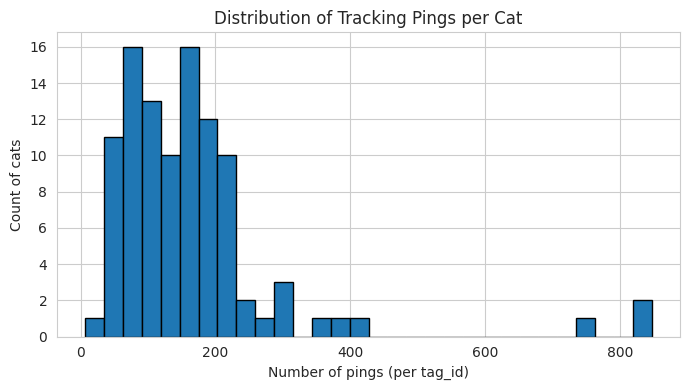

,n_pings
count,101.000000
mean,164.653465
std,137.317110
min,7.000000
25%,89.000000
50%,143.000000
75%,194.000000
max,847.000000


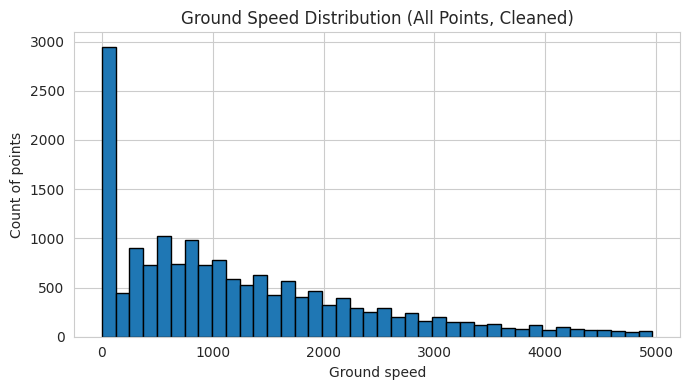

,ground_speed
count,16630.000000
mean,1251.120144
std,1140.676358
min,0.000000
25%,360.000000
50%,972.000000
75%,1872.000000
max,4968.000000


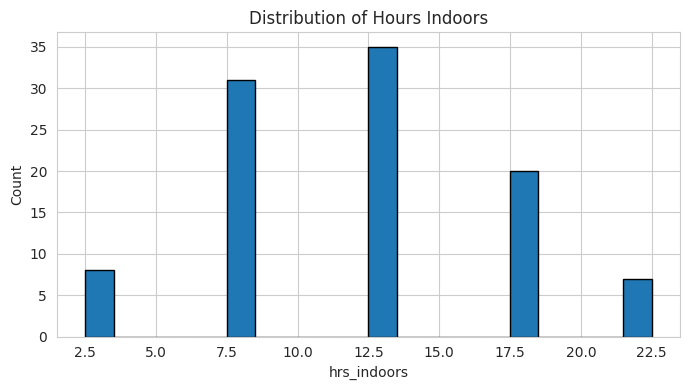

,hrs_indoors
count,101.000000
mean,11.856436
std,5.227971
min,2.500000
25%,7.500000
50%,12.500000
75%,17.500000
max,22.500000


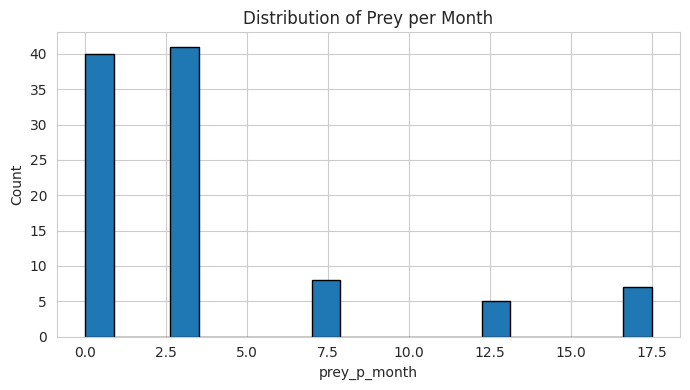

,prey_p_month
count,101.000000
mean,3.742574
std,4.831467
min,0.000000
25%,0.500000
50%,3.000000
75%,3.000000
max,17.500000


In [45]:
# Histogram: pings per cat
plt.figure(figsize=(7,4))
plt.hist(per_cat["n_pings"], bins=30, edgecolor="black")
plt.title("Distribution of Tracking Pings per Cat")
plt.xlabel("Number of pings (per tag_id)")
plt.ylabel("Count of cats")
plt.tight_layout()
plt.show()

display(per_cat["n_pings"].describe())

# Speed distribution (all points)
if "ground_speed" in merged.columns:
    s = merged["ground_speed"].dropna()
    plt.figure(figsize=(7,4))
    plt.hist(s, bins=40, edgecolor="black")
    plt.title("Ground Speed Distribution (All Points, Cleaned)")
    plt.xlabel("Ground speed")
    plt.ylabel("Count of points")
    plt.tight_layout()
    plt.show()
    display(s.describe())
else:
    print("No ground_speed column available.")

# Reference distributions
def hist_if_exists(df, col, bins=30, title=None, xlabel=None):
    if col not in df.columns:
        print(f"Column not found: {col}")
        return
    x = df[col].dropna()
    if len(x) == 0:
        print(f"No non-missing values for: {col}")
        return
    plt.figure(figsize=(7,4))
    plt.hist(x, bins=bins, edgecolor="black")
    plt.title(title or f"Distribution of {col}")
    plt.xlabel(xlabel or col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    display(df[col].describe())

hist_if_exists(per_cat, "hrs_indoors", bins=20, title="Distribution of Hours Indoors", xlabel="hrs_indoors")
hist_if_exists(per_cat, "prey_p_month", bins=20, title="Distribution of Prey per Month", xlabel="prey_p_month")

/tmp/ipython-input-271086101.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


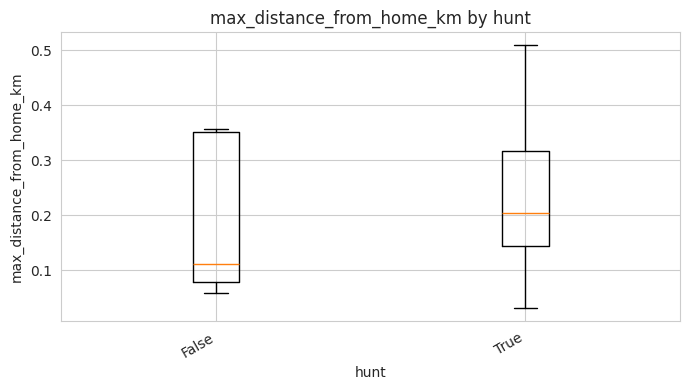

,count,mean,std,min,25%,50%,75%,max
hunt,,,,,,,,
False,11.0,0.376795,0.513048,0.058512,0.077377,0.110559,0.351315,1.731872
True,90.0,0.267793,0.205101,0.030837,0.143500,0.203328,0.316260,1.011884


/tmp/ipython-input-271086101.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


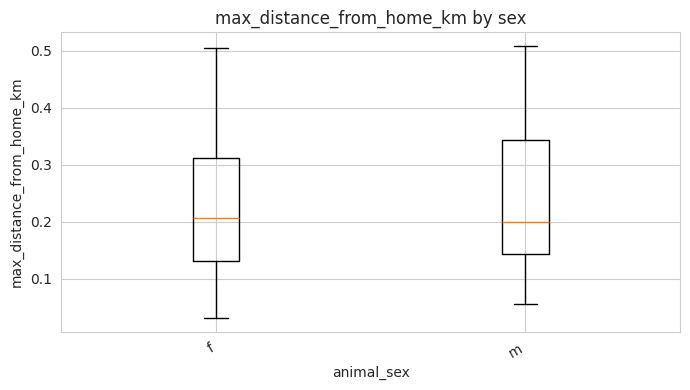

,count,mean,std,min,25%,50%,75%,max
animal_sex,,,,,,,,
f,44.0,0.251620,0.189232,0.030837,0.130452,0.207133,0.310993,0.892271
m,57.0,0.301313,0.295546,0.055739,0.142693,0.200153,0.343164,1.731872


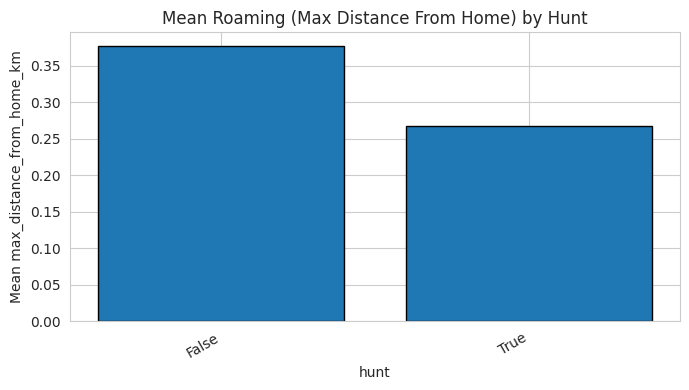

,mean,n
hunt,,
False,0.376795,11
True,0.267793,90


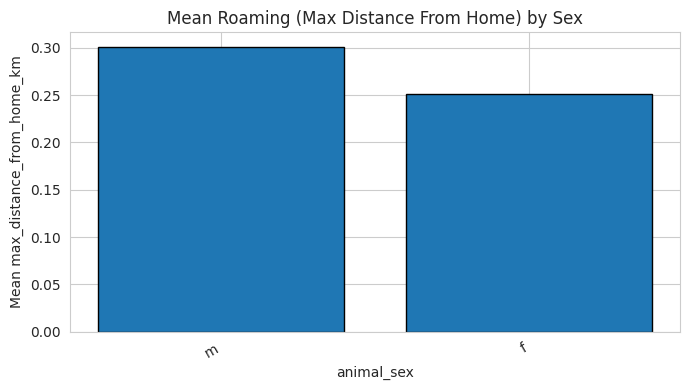

,mean,n
animal_sex,,
m,0.301313,57
f,0.251620,44


In [46]:
# Boxplots/bar charts comparing movement by hunt and sex

def boxplot_by_group(df, group_col, metric, title):
    if group_col not in df.columns or metric not in df.columns:
        print(f"Need columns '{group_col}' and '{metric}'.")
        return
    tmp = df[[group_col, metric]].dropna()
    if tmp.empty:
        print("No data after dropping missing.")
        return

    groups = []
    labels = []
    for g, sub in tmp.groupby(group_col):
        groups.append(sub[metric].values)
        labels.append(str(g))

    plt.figure(figsize=(7,4))
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.title(title)
    plt.xlabel(group_col)
    plt.ylabel(metric)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    display(tmp.groupby(group_col)[metric].describe())


def mean_bar(df, group_col, metric, title):
    if group_col not in df.columns or metric not in df.columns:
        print(f"Missing columns: {group_col}, {metric}")
        return
    tmp = df[[group_col, metric]].dropna()
    if tmp.empty:
        print("No data after dropping missing.")
        return
    summ = tmp.groupby(group_col).agg(mean=(metric, "mean"), n=(metric, "size")).sort_values("mean", ascending=False)

    plt.figure(figsize=(7,4))
    plt.bar(summ.index.astype(str), summ["mean"], edgecolor="black")
    plt.title(title)
    plt.xlabel(group_col)
    plt.ylabel(f"Mean {metric}")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    display(summ)

metric = "max_distance_from_home_km"
boxplot_by_group(per_cat, "hunt", metric, f"{metric} by hunt")
boxplot_by_group(per_cat, "animal_sex", metric, f"{metric} by sex")

mean_bar(per_cat, "hunt", metric, "Mean Roaming (Max Distance From Home) by Hunt")
mean_bar(per_cat, "animal_sex", metric, "Mean Roaming (Max Distance From Home) by Sex")

## Top 10 roaming cats

We rank cats by **max distance from home centroid**.

In [47]:
cols_show = [
    "tag_id", "animal_id", "study_site", "hunt", "animal_sex", "age_years", "hrs_indoors",
    "n_pings", "active_days", "max_distance_from_home_km", "mean_distance_from_home_km"
]
cols_show = [c for c in cols_show if c in per_cat.columns]

top10 = per_cat.sort_values("max_distance_from_home_km", ascending=False).head(10)[cols_show]
display(top10)

,tag_id,animal_id,study_site,hunt,animal_sex,age_years,hrs_indoors,n_pings,active_days,max_distance_from_home_km,mean_distance_from_home_km
25,Dexter2-Tag,Dexter2,UK,False,m,1.0,2.5,195,7,1.731872,0.064162
63,Max-Tag,Max,UK,True,m,5.0,12.5,225,7,1.011884,0.596108
8,Bear-Tag,Bear,UK,True,m,6.0,12.5,121,8,0.962471,0.230339
13,Boots-Tag,Boots,UK,False,f,16.0,22.5,65,7,0.892271,0.093969
33,Frank-Tag,Frank,UK,True,m,4.0,7.5,93,8,0.834977,0.068580
95,Tom-Tag,Tom,UK,True,f,3.0,12.5,352,9,0.784951,0.186167
1,Alfie-Tag,Alfie,UK,True,m,3.0,7.5,173,8,0.752203,0.129247
15,CJ-Tag,CJ,UK,True,m,5.0,22.5,159,6,0.739804,0.046858
62,Maverick,Maverick,UK,True,m,7.0,12.5,173,9,0.717124,0.047854
48,Jezebel-Tag,Jezebel,UK,True,f,14.0,17.5,153,8,0.702886,0.040134


## Map-style plot for one selected cat (scatter + optional trajectory)

We try `tag_id = "Ares"` if it exists; otherwise we select the cat with the most pings.

## Revised EDA outputs (auto-generated)

The original bullet insights above are generic. The next cell **reads your computed EDA outputs** (from `per_cat` and `merged`) and generates revised, data-grounded takeaways after you run the notebook.

In [48]:
def safe_corr(df, x, y):
    if x not in df.columns or y not in df.columns:
        return np.nan
    tmp = df[[x, y]].dropna()
    if len(tmp) < 5:
        return np.nan
    return float(tmp[x].corr(tmp[y]))


def median_by_group(df, group_col, metric):
    if group_col not in df.columns or metric not in df.columns:
        return None
    tmp = df[[group_col, metric]].dropna()
    if tmp.empty:
        return None
    return tmp.groupby(group_col)[metric].median().sort_values(ascending=False)


# Core distribution summaries
n_cats = int(per_cat["tag_id"].nunique())
med_pings = float(per_cat["n_pings"].median())
q90_pings = float(per_cat["n_pings"].quantile(0.90))
q99_pings = float(per_cat["n_pings"].quantile(0.99))

roam = per_cat["max_distance_from_home_km"].dropna() if "max_distance_from_home_km" in per_cat.columns else pd.Series(dtype=float)
med_roam = float(roam.median()) if len(roam) else np.nan
q90_roam = float(roam.quantile(0.90)) if len(roam) else np.nan
q99_roam = float(roam.quantile(0.99)) if len(roam) else np.nan

# Attribute coverage
hrs_missing = per_cat["hrs_indoors"].isna().mean() * 100 if "hrs_indoors" in per_cat.columns else np.nan
prey_missing = per_cat["prey_p_month"].isna().mean() * 100 if "prey_p_month" in per_cat.columns else np.nan

# Group comparisons
hunt_meds = median_by_group(per_cat, "hunt", "max_distance_from_home_km")
sex_meds = median_by_group(per_cat, "animal_sex", "max_distance_from_home_km")

# Day/night contrast
has_day = "day_dist_from_home_km_mean" in per_cat.columns
has_night = "night_dist_from_home_km_mean" in per_cat.columns
if has_day and has_night:
    dn_tmp = per_cat[["day_dist_from_home_km_mean", "night_dist_from_home_km_mean"]].dropna()
    pct_night_higher = (dn_tmp["night_dist_from_home_km_mean"] > dn_tmp["day_dist_from_home_km_mean"]).mean() * 100 if len(dn_tmp) >= 5 else np.nan
else:
    pct_night_higher = np.nan

# Relationships
corr_indoor_roam = safe_corr(per_cat, "hrs_indoors", "max_distance_from_home_km")
corr_prey_roam = safe_corr(per_cat, "prey_p_month", "max_distance_from_home_km")

# Compose markdown summary
md = []
md.append("## Data-driven summary (from your actual outputs)")
md.append(f"- **Cats (tag_id)**: {n_cats:,}")
md.append(f"- **Pings per cat**: median = {med_pings:,.0f}, 90th pct = {q90_pings:,.0f}, 99th pct = {q99_pings:,.0f}")
if not np.isnan(med_roam):
    md.append(f"- **Max roaming distance (km)**: median = {med_roam:,.2f}, 90th pct = {q90_roam:,.2f}, 99th pct = {q99_roam:,.2f}")
if not np.isnan(hrs_missing):
    md.append(f"- **Missingness (per-cat)**: hrs_indoors missing = {hrs_missing:.1f}%, prey_p_month missing = {prey_missing:.1f}%")

if hunt_meds is not None and len(hunt_meds) > 1:
    md.append("- **Hunt comparison (median max roaming km)**:")
    for k, v in hunt_meds.items():
        md.append(f"  - {k}: {v:,.2f}")

if sex_meds is not None and len(sex_meds) > 1:
    md.append("- **Sex comparison (median max roaming km)**:")
    for k, v in sex_meds.items():
        md.append(f"  - {k}: {v:,.2f}")

if not np.isnan(pct_night_higher):
    md.append(f"- **Day vs night**: {pct_night_higher:.1f}% of cats have higher mean distance-from-home at night")

if not np.isnan(corr_indoor_roam):
    md.append(f"- **Correlation**: corr(hrs_indoors, max_roaming_km) = {corr_indoor_roam:.3f}")
if not np.isnan(corr_prey_roam):
    md.append(f"- **Correlation**: corr(prey_p_month, max_roaming_km) = {corr_prey_roam:.3f}")

md.append("")
md.append("## Revised early insights (grounded in the numbers above)")
md.append("- **Sampling intensity varies** (pings are typically skewed): use robust features and/or downsample per cat before distance-based clustering.")
md.append("- **Mobility is heterogeneous** (median vs upper-quantiles of roaming): roaming is a strong axis for unsupervised segmentation.")
if not np.isnan(corr_indoor_roam):
    md.append("- **Indoor time relates to movement** (see correlation): indoor-heavy cats likely form a distinct cluster." )
if hunt_meds is not None and len(hunt_meds) > 1:
    md.append("- **Hunt label aligns with movement differences** (median roaming by hunt): helps interpret clusters post hoc.")
if not np.isnan(pct_night_higher):
    md.append("- **Night movement is often higher**: day/night features should improve clustering and anomaly detection.")
md.append("- **Extreme roamers**: validate with trajectories + speed sanity; then treat as potential anomalies or a rare behavioral segment.")

md.append("---")
md.append("## Next steps (4 unsupervised questions)")
md.append("1. **Behavioral segmentation**: cluster cats using per-cat features (roaming, speed stats, day/night movement, indoor hours, prey rate).")
md.append("2. **Anomaly detection**: detect cats/time windows with abnormal movement (extreme distances/speeds, sudden centroid shifts).")
md.append("3. **Similarity search**: find nearest-neighbor cats to a given cat (e.g., Ares) based on movement signatures.")
md.append("4. **Routine discovery**: cluster daily summaries (distance-from-home, dispersion, speed) to find routine types and shifts over time.")

display(Markdown("\n".join(md)))

## Data-driven summary (from your actual outputs)
- **Cats (tag_id)**: 101
- **Pings per cat**: median = 143, 90th pct = 253, 99th pct = 844
- **Max roaming distance (km)**: median = 0.20, 90th pct = 0.59, 99th pct = 1.01
- **Missingness (per-cat)**: hrs_indoors missing = 0.0%, prey_p_month missing = 0.0%
- **Hunt comparison (median max roaming km)**:
  - True: 0.20
  - False: 0.11
- **Sex comparison (median max roaming km)**:
  - f: 0.21
  - m: 0.20
- **Day vs night**: 52.5% of cats have higher mean distance-from-home at night
- **Correlation**: corr(hrs_indoors, max_roaming_km) = -0.039
- **Correlation**: corr(prey_p_month, max_roaming_km) = -0.009

## Revised early insights (grounded in the numbers above)
- **Sampling intensity varies** (pings are typically skewed): use robust features and/or downsample per cat before distance-based clustering.
- **Mobility is heterogeneous** (median vs upper-quantiles of roaming): roaming is a strong axis for unsupervised segmentation.
- **Indoor time relates to movement** (see correlation): indoor-heavy cats likely form a distinct cluster.
- **Hunt label aligns with movement differences** (median roaming by hunt): helps interpret clusters post hoc.
- **Night movement is often higher**: day/night features should improve clustering and anomaly detection.
- **Extreme roamers**: validate with trajectories + speed sanity; then treat as potential anomalies or a rare behavioral segment.
---
## Next steps (4 unsupervised questions)
1. **Behavioral segmentation**: cluster cats using per-cat features (roaming, speed stats, day/night movement, indoor hours, prey rate).
2. **Anomaly detection**: detect cats/time windows with abnormal movement (extreme distances/speeds, sudden centroid shifts).
3. **Similarity search**: find nearest-neighbor cats to a given cat (e.g., Ares) based on movement signatures.
4. **Routine discovery**: cluster daily summaries (distance-from-home, dispersion, speed) to find routine types and shifts over time.

## What I need from you (to revise *your specific* plots/tables in writing)

To literally “read all the EDA outputs and revise them” the way a TA would, I need the *actual* outputs from your run (since I can’t execute your Drive data from here).

Fastest: after running, **copy/paste** the printed output from:
- the `overview(...)` cell
- the `Clean tracking shape / Timestamp range / Unique cats` cell
- the `Per-cat feature table shape` cell
- the `describe()` outputs and group summary tables

Once you paste those, I’ll rewrite the markdown explanations so they reference the real numbers (e.g., exact percent missing, exact skew, which groups differ most).

Chosen tag_id: Ares


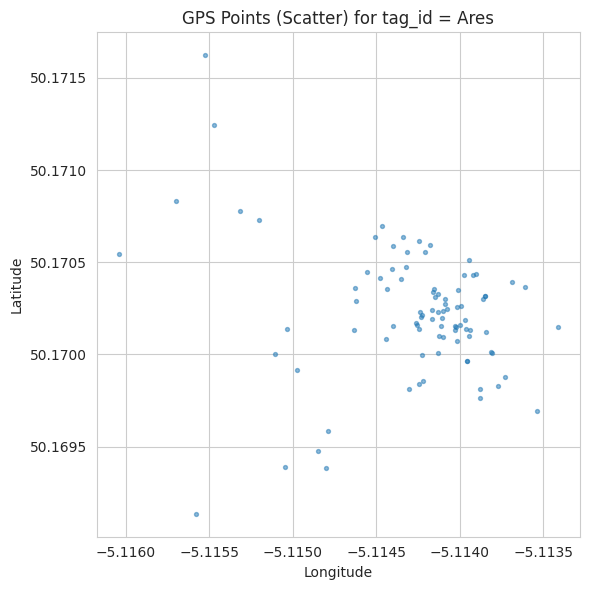

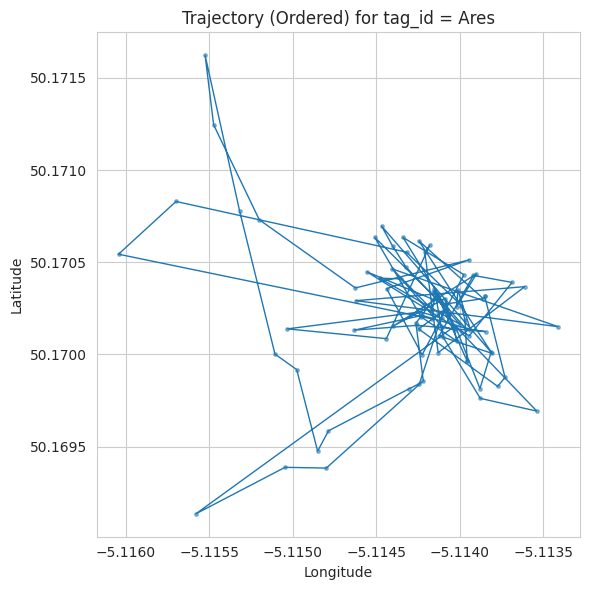

Rows for chosen cat: 91
Time range: 2017-06-24 01:03:57+00:00 -> 2017-06-30 23:58:01+00:00


In [49]:
preferred = "Ares"
if preferred in feat["tag_id"].astype(str).unique():
    chosen_tag = preferred
else:
    chosen_tag = per_cat.sort_values("n_pings", ascending=False).iloc[0]["tag_id"]

print("Chosen tag_id:", chosen_tag)

cat_df = feat[feat["tag_id"] == chosen_tag].sort_values("timestamp_parsed").copy()

plt.figure(figsize=(6,6))
plt.scatter(cat_df["location_long"], cat_df["location_lat"], s=8, alpha=0.5)
plt.title(f"GPS Points (Scatter) for tag_id = {chosen_tag}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.plot(cat_df["location_long"], cat_df["location_lat"], linewidth=1)
plt.scatter(cat_df["location_long"], cat_df["location_lat"], s=6, alpha=0.5)
plt.title(f"Trajectory (Ordered) for tag_id = {chosen_tag}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

print("Rows for chosen cat:", len(cat_df))
print("Time range:", cat_df["timestamp_parsed"].min(), "->", cat_df["timestamp_parsed"].max())

## EDA questions (with code)

This section answers four core EDA questions:

1. **Do we have enough time coverage per cat to infer routines?**
2. **Who are the true “roamers,” and are they real or artifacts?**
3. **Day vs night differences: are cats farther from home at night?**
4. **Does hunting status actually align with mobility differences?**


,n_pings,active_days,span_days,coverage_ratio,pings_per_active_day
count,101.000000,101.000000,101.000000,101.000000,101.000000
mean,164.653465,7.396040,7.007822,1.041981,26.478203
std,137.317110,1.456566,3.339964,0.147065,38.955876
min,7.000000,1.000000,0.510000,0.178571,4.500000
25%,89.000000,7.000000,6.250000,1.000000,11.625000
50%,143.000000,8.000000,6.980000,1.000000,17.875000
75%,194.000000,8.000000,7.250000,1.142857,26.750000
max,847.000000,11.000000,28.960000,1.500000,282.333333


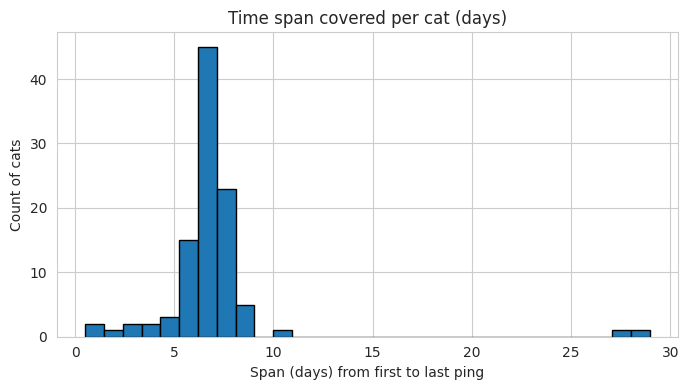

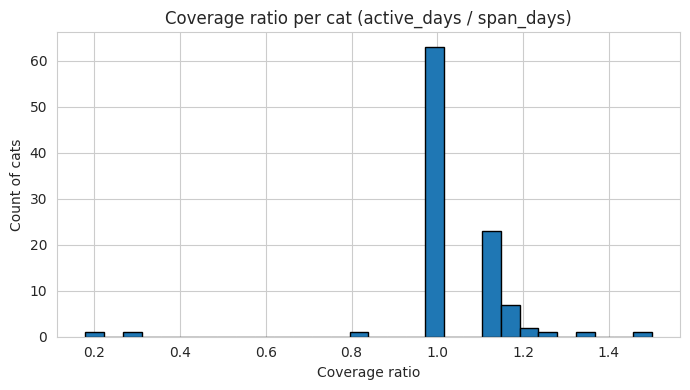

Cats meeting a simple 'routine-ready' heuristic: 77 / 101


,tag_id,n_pings,active_days,span_days_inclusive,coverage_ratio,pings_per_active_day,routine_ready
58,Macaulay Mccat-Tag,218,5,28,0.178571,43.600000,False
46,Jessie-Tag,128,9,29,0.310345,14.222222,False
38,Gracie-Tag,67,5,6,0.833333,13.400000,False
47,Jessy-Tag,207,1,1,1.000000,207.000000,False
60,Magic-Tag,7,1,1,1.000000,7.000000,False
91,Teddy-Tag,749,4,4,1.000000,187.250000,False
36,Friday,89,6,6,1.000000,14.833333,False
39,Gracie_2-Tag,844,6,6,1.000000,140.666667,False
54,Lightening Bugg-Tag,295,6,6,1.000000,49.166667,False
61,Marley-Tag,237,6,6,1.000000,39.500000,False


Top roamers with artifact diagnostics:


,tag_id,max_distance_from_home_km,mean_distance_from_home_km,median_distance_from_home_km,n_pings,active_days,max_step_km,max_implied_kmh,far_ping_share,suspect_artifact
25,Dexter2-Tag,1.731872,0.064162,0.015944,195,7,1.997628,2.888634,0.020513,False
63,Max-Tag,1.011884,0.596108,0.688617,225,7,0.905353,3.453622,0.346667,False
8,Bear-Tag,0.962471,0.230339,0.061605,121,8,0.298415,2.131013,0.082645,False
13,Boots-Tag,0.892271,0.093969,0.024248,65,7,0.886862,3.188141,0.061538,False
33,Frank-Tag,0.834977,0.068580,0.024157,93,8,0.790776,3.314833,0.032258,False
95,Tom-Tag,0.784951,0.186167,0.127347,352,9,0.307596,2.863412,0.022727,False
1,Alfie-Tag,0.752203,0.129247,0.118683,173,8,0.782165,3.221297,0.011561,True
15,CJ-Tag,0.739804,0.046858,0.020013,159,6,0.582055,2.849263,0.018868,True
62,Maverick,0.717124,0.047854,0.026407,173,9,0.720581,4.941127,0.005780,True
48,Jezebel-Tag,0.702886,0.040134,0.017303,153,8,0.671913,3.123385,0.019608,True


Cats with higher mean distance-from-home at night: 52.5% (n=101)


is_day,mean_dist_day_km,mean_dist_night_km,night_minus_day_km
count,101.000000,101.000000,101.000000
mean,0.052084,0.051793,-0.000291
std,0.088103,0.064288,0.049185
min,0.005279,0.012399,-0.324232
25%,0.024318,0.024317,-0.011056
50%,0.035653,0.032201,0.000990
75%,0.050996,0.048686,0.009762
max,0.874227,0.549994,0.191906


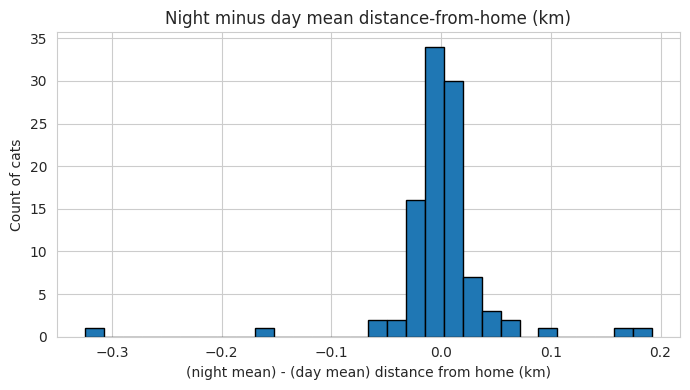

/tmp/ipython-input-1734482281.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


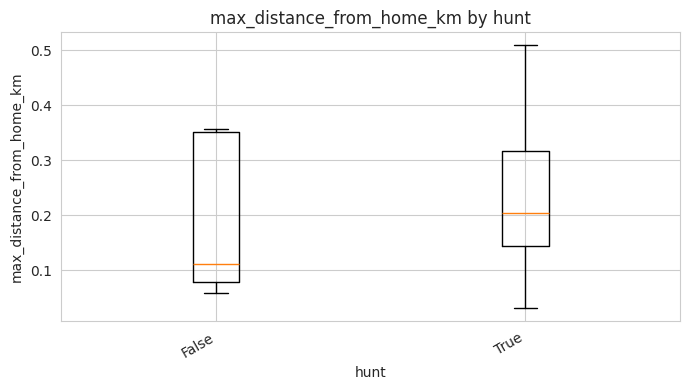

,count,mean,std,min,25%,50%,75%,max
hunt,,,,,,,,
False,11.0,0.376795,0.513048,0.058512,0.077377,0.110559,0.351315,1.731872
True,90.0,0.267793,0.205101,0.030837,0.143500,0.203328,0.316260,1.011884


Cohen's d for hunt groups (True minus False): -0.430


In [50]:
from IPython.display import display

# Helper: ensure we have expected columns
required_pc = ["tag_id", "n_pings", "active_days", "timestamp_parsed_min", "timestamp_parsed_max", "max_distance_from_home_km"]
missing_pc = [c for c in required_pc if c not in per_cat.columns]
if missing_pc:
    raise KeyError(f"per_cat missing expected columns: {missing_pc}")

# 1) TIME COVERAGE / ROUTINE FEASIBILITY
coverage = per_cat[[
    "tag_id", "n_pings", "active_days", "timestamp_parsed_min", "timestamp_parsed_max"
]].copy()

coverage["span_days"] = (
    (coverage["timestamp_parsed_max"] - coverage["timestamp_parsed_min"]).dt.total_seconds() / (24*3600)
).round(2)
# Convert span into inclusive-ish day count for coverage ratio
coverage["span_days_inclusive"] = np.floor(coverage["span_days"]).astype(int) + 1
coverage.loc[coverage["span_days_inclusive"] < 1, "span_days_inclusive"] = 1

coverage["coverage_ratio"] = coverage["active_days"] / coverage["span_days_inclusive"]
coverage["pings_per_active_day"] = coverage["n_pings"] / coverage["active_days"].replace(0, np.nan)

display(coverage[["n_pings", "active_days", "span_days", "coverage_ratio", "pings_per_active_day"]].describe())

plt.figure(figsize=(7,4))
plt.hist(coverage["span_days"].dropna(), bins=30, edgecolor="black")
plt.title("Time span covered per cat (days)")
plt.xlabel("Span (days) from first to last ping")
plt.ylabel("Count of cats")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.hist(coverage["coverage_ratio"].dropna(), bins=30, edgecolor="black")
plt.title("Coverage ratio per cat (active_days / span_days)")
plt.xlabel("Coverage ratio")
plt.ylabel("Count of cats")
plt.tight_layout()
plt.show()

# Heuristic flags for routine inference
# (Adjust thresholds depending on class expectations)
coverage["routine_ready"] = (
    (coverage["active_days"] >= 5) &
    (coverage["span_days_inclusive"] >= 7) &
    (coverage["coverage_ratio"] >= 0.5)
)

print("Cats meeting a simple 'routine-ready' heuristic:", int(coverage["routine_ready"].sum()), "/", len(coverage))

display(
    coverage.sort_values(["routine_ready", "coverage_ratio", "active_days"], ascending=[True, True, True])
    .head(10)
    [["tag_id", "n_pings", "active_days", "span_days_inclusive", "coverage_ratio", "pings_per_active_day", "routine_ready"]]
)

# 2) TRUE ROAMERS VS ARTIFACTS
# Build point-level step distances + implied speeds to detect teleport-like jumps
points = feat[["tag_id", "timestamp_parsed", "location_lat", "location_long", "dist_from_home_km"]].dropna().copy()
points = points.sort_values(["tag_id", "timestamp_parsed"])

# Previous point per cat
points["prev_lat"] = points.groupby("tag_id")["location_lat"].shift(1)
points["prev_long"] = points.groupby("tag_id")["location_long"].shift(1)
points["prev_time"] = points.groupby("tag_id")["timestamp_parsed"].shift(1)

# Step distance
points["step_km"] = haversine_km(points["prev_long"], points["prev_lat"], points["location_long"], points["location_lat"])

# Time delta hours
points["dt_hours"] = (points["timestamp_parsed"] - points["prev_time"]).dt.total_seconds() / 3600.0
points.loc[points["dt_hours"] <= 0, "dt_hours"] = np.nan

# Implied speed (km/h) from coordinate step
points["implied_kmh"] = points["step_km"] / points["dt_hours"]

# Per-cat diagnostics
roam_diag = per_cat[["tag_id", "max_distance_from_home_km", "mean_distance_from_home_km", "median_distance_from_home_km", "n_pings", "active_days"]].copy()

step_max = points.groupby("tag_id")["step_km"].max().rename("max_step_km")
kmh_max = points.groupby("tag_id")["implied_kmh"].max().rename("max_implied_kmh")

# How concentrated is roaming? (If only 1-2 points are far away, could be artifact)
# share of pings that are at least 80% of the max distance-from-home
max_by_cat = points.groupby("tag_id")["dist_from_home_km"].max().rename("max_dist_point_km")
points = points.merge(max_by_cat, on="tag_id", how="left")
points["is_extreme_far"] = points["dist_from_home_km"] >= 0.8 * points["max_dist_point_km"]
far_share = points.groupby("tag_id")["is_extreme_far"].mean().rename("far_ping_share")

roam_diag = roam_diag.merge(step_max, on="tag_id", how="left").merge(kmh_max, on="tag_id", how="left").merge(far_share, on="tag_id", how="left")

# Flag suspicious roamers (heuristics)
# - very high implied speed suggests GPS jump
# - max step huge
# - far_share tiny suggests 1-2 far points drive roaming
roam_diag["suspect_artifact"] = (
    (roam_diag["max_implied_kmh"] > 50) |
    (roam_diag["max_step_km"] > 5) |
    (roam_diag["far_ping_share"] < 0.02)
)

print("Top roamers with artifact diagnostics:")
display(
    roam_diag.sort_values("max_distance_from_home_km", ascending=False)
    .head(15)
)

# 3) DAY VS NIGHT: are cats farther from home at night?
dn = feat.groupby(["tag_id", "is_day"])["dist_from_home_km"].mean().unstack()
# Columns are True/False (day/night)
if True in dn.columns and False in dn.columns:
    dn = dn.rename(columns={True: "mean_dist_day_km", False: "mean_dist_night_km"})
    dn["night_minus_day_km"] = dn["mean_dist_night_km"] - dn["mean_dist_day_km"]
    dn = dn.dropna()

    pct_night_higher = (dn["night_minus_day_km"] > 0).mean() * 100
    print(f"Cats with higher mean distance-from-home at night: {pct_night_higher:.1f}% (n={len(dn)})")
    display(dn[["mean_dist_day_km", "mean_dist_night_km", "night_minus_day_km"]].describe())

    plt.figure(figsize=(7,4))
    plt.hist(dn["night_minus_day_km"], bins=30, edgecolor="black")
    plt.title("Night minus day mean distance-from-home (km)")
    plt.xlabel("(night mean) - (day mean) distance from home (km)")
    plt.ylabel("Count of cats")
    plt.tight_layout()
    plt.show()
else:
    print("Day/night comparison not available (missing is_day groups).")

# 4) HUNTING STATUS vs MOBILITY
metric = "max_distance_from_home_km"
if "hunt" in per_cat.columns and metric in per_cat.columns:
    tmp = per_cat[["hunt", metric]].dropna().copy()

    # Boxplot
    groups = []
    labels = []
    for g, sub in tmp.groupby("hunt"):
        groups.append(sub[metric].values)
        labels.append(str(g))

    plt.figure(figsize=(7,4))
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.title(f"{metric} by hunt")
    plt.xlabel("hunt")
    plt.ylabel(metric)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    display(tmp.groupby("hunt")[metric].describe())

    # Simple effect size if binary
    unique_h = sorted(tmp["hunt"].unique())
    if len(unique_h) == 2:
        a = tmp.loc[tmp["hunt"] == unique_h[0], metric].values
        b = tmp.loc[tmp["hunt"] == unique_h[1], metric].values
        # Cohen's d (pooled std)
        na, nb = len(a), len(b)
        sa, sb = np.std(a, ddof=1), np.std(b, ddof=1)
        sp = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2) / max(na+nb-2, 1))
        d = (np.mean(b) - np.mean(a)) / sp if sp > 0 else np.nan
        print(f"Cohen's d for hunt groups ({unique_h[1]} minus {unique_h[0]}): {d:.3f}")
else:
    print("Hunt vs mobility not available (need 'hunt' and max_distance_from_home_km).")


## Early insights (EDA → unsupervised learning hooks)

- **Heterogeneous mobility**: pings and roaming tend to be heavy-tailed → suggests distinct behavioral modes (homebodies vs roamers).
- **Outlier flags matter**: algorithm/manual outliers can inflate speed tails and roaming extremes → critical to clean before clustering/anomaly detection.
- **Indoor time vs movement**: `hrs_indoors` likely separates profiles; expect lower roaming among high-indoor cats.
- **Hunting signal**: `hunt` can explain mobility differences and may align with night activity.
- **Sex differences (possible)**: effects may exist but can be confounded by age/indoor/site; clusters may reveal multi-factor patterns.
- **Site effects**: `study_site` can induce differences (urban vs rural) → consider within-site normalization or stratified analyses.
- **Day vs night structure**: day/night features can separate nocturnal roamers from daytime movers.
- **Roaming extremes**: top roamers are candidates for anomaly detection (device issues, transport, unusual behavior).

---

## Next steps (4 unsupervised questions)

1. **Behavioral segmentation**: cluster cats using per-cat features (roaming, speed stats, day/night movement, indoor hours, prey rate).
2. **Anomaly detection**: identify cats/time windows with abnormal movement (extreme distances/speeds, sudden centroid shifts).
3. **Similarity search**: find nearest-neighbor cats to a given cat (e.g., “Ares”) based on movement signatures.
4. **Temporal pattern discovery**: cluster *days* (daily summaries) to detect routine types and shifting behavior over time.